# Mitochondria segmentation in EM with 2D U-Net

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import os
import sys
from skimage.io import imread                                                   
from PIL import Image
import numpy as np
from tqdm import tqdm


Firstly, download the repository (V1.0 version of it)

In [2]:
!wget https://github.com/danifranco/EM_Image_Segmentation/archive/refs/tags/v1.0.tar.gz
!tar -xzvf v1.0.tar.gz

--2021-04-17 16:36:38--  https://github.com/danifranco/EM_Image_Segmentation/archive/refs/tags/v1.0.tar.gz
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/danifranco/EM_Image_Segmentation/tar.gz/refs/tags/v1.0 [following]
--2021-04-17 16:36:38--  https://codeload.github.com/danifranco/EM_Image_Segmentation/tar.gz/refs/tags/v1.0
Resolving codeload.github.com (codeload.github.com)... 140.82.114.10
Connecting to codeload.github.com (codeload.github.com)|140.82.114.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/x-gzip]
Saving to: ‘v1.0.tar.gz’

v1.0.tar.gz             [          <=>       ]  37.86M  20.6MB/s    in 1.8s    

2021-04-17 16:36:40 (20.6 MB/s) - ‘v1.0.tar.gz’ saved [39702131]

EM_Image_Segmentation-1.0/
EM_Image_Segmentation-1.0/.gitignore
EM_Image_Segmentation-1.0/.

Install dependencies:

In [3]:
!pip install git+https://github.com/aleju/imgaug.git

  Cloning https://github.com/aleju/imgaug.git to /tmp/pip-req-build-0d_20o1e
  Running command git clone -q https://github.com/aleju/imgaug.git /tmp/pip-req-build-0d_20o1e
  Created wheel for imgaug: filename=imgaug-0.4.0-cp37-none-any.whl size=971106 sha256=c3857b3b9ae781a95386c4f21bbd8c65fc997d4ab80767e74f243a14db0f2345
  Stored in directory: /tmp/pip-ephem-wheel-cache-39assiyl/wheels/65/3d/94/ee32cbeaa29c473a4db74c2d21904ac747311fdca4732665f0
Successfully built imgaug
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.4.0 which is incompatible.
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9


Download the EPFL Hippocampus dataset (Lucchi dataset)

In [4]:
if not os.path.exists('training.tif'):
    !wget https://documents.epfl.ch/groups/c/cv/cvlab-unit/www/data/%20ElectronMicroscopy_Hippocampus/training.tif
if not os.path.exists('training_groundtruth.tif'):
    !wget https://documents.epfl.ch/groups/c/cv/cvlab-unit/www/data/%20ElectronMicroscopy_Hippocampus/training_groundtruth.tif
if not os.path.exists('testing.tif'):
    !wget https://documents.epfl.ch/groups/c/cv/cvlab-unit/www/data/%20ElectronMicroscopy_Hippocampus/testing.tif
if not os.path.exists('testing_groundtruth.tif'):
    !wget https://documents.epfl.ch/groups/c/cv/cvlab-unit/www/data/%20ElectronMicroscopy_Hippocampus/testing_groundtruth.tif

--2021-04-17 16:36:49--  https://documents.epfl.ch/groups/c/cv/cvlab-unit/www/data/%20ElectronMicroscopy_Hippocampus/training.tif
Resolving documents.epfl.ch (documents.epfl.ch)... 128.178.222.197, 2001:620:618:1de:1:80b2:dec5:1
Connecting to documents.epfl.ch (documents.epfl.ch)|128.178.222.197|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 129919357 (124M) [application/octet-stream]
Saving to: ‘training.tif’

training.tif        100%[===================>] 123.90M  1.53MB/s    in 1m 55s  

2021-04-17 16:38:45 (1.07 MB/s) - ‘training.tif’ saved [129919357/129919357]

--2021-04-17 16:38:45--  https://documents.epfl.ch/groups/c/cv/cvlab-unit/www/data/%20ElectronMicroscopy_Hippocampus/training_groundtruth.tif
Resolving documents.epfl.ch (documents.epfl.ch)... 128.178.222.197, 2001:620:618:1de:1:80b2:dec5:1
Connecting to documents.epfl.ch (documents.epfl.ch)|128.178.222.197|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 129919357 (124M)

## Prepare dataset in correct folders readable by the template 

In [5]:
!mkdir -p dataset/train/x dataset/train/y dataset/test/x dataset/test/y
train_save_data = 'dataset/train/x'
train_save_mask = 'dataset/train/y'
test_save_data = 'dataset/test/x'
test_save_mask = 'dataset/test/y'

**Train data**:

In [6]:
X_train = imread('training.tif')
Y_train = imread('training_groundtruth.tif')

In [7]:
d = len(str(X_train.shape[0]))
for i in tqdm(range(X_train.shape[0])):
    # Data
    im = Image.fromarray((X_train[i]).astype(np.uint8))
    im = im.convert('L')
    f = os.path.join(train_save_data , "x_" + str(i).zfill(d) + '.tif')
    im.save(f)

    # Mask
    im = Image.fromarray((Y_train[i]).astype(np.uint8))
    im = im.convert('L')
    f = os.path.join(train_save_mask , "y_" + str(i).zfill(d) + '.tif')
    im.save(f)

100%|██████████| 165/165 [00:00<00:00, 278.17it/s]


In [8]:
del X_train, Y_train

**Test data**:

In [9]:
X_test = imread('testing.tif')
Y_test = imread('testing_groundtruth.tif')

In [10]:
d = len(str(X_test.shape[0]))
for i in tqdm(range(X_test.shape[0])):
    # Data
    im = Image.fromarray((X_test[i]).astype(np.uint8))
    im = im.convert('L')
    f = os.path.join(test_save_data , "x_" + str(i).zfill(d) + '.tif')
    im.save(f)

    # Mask
    im = Image.fromarray((Y_test[i]).astype(np.uint8))
    im = im.convert('L')
    f = os.path.join(test_save_mask , "y_" + str(i).zfill(d) + '.tif')
    im.save(f)

100%|██████████| 165/165 [00:00<00:00, 260.24it/s]


In [11]:
del X_test, Y_test

Check data samples:

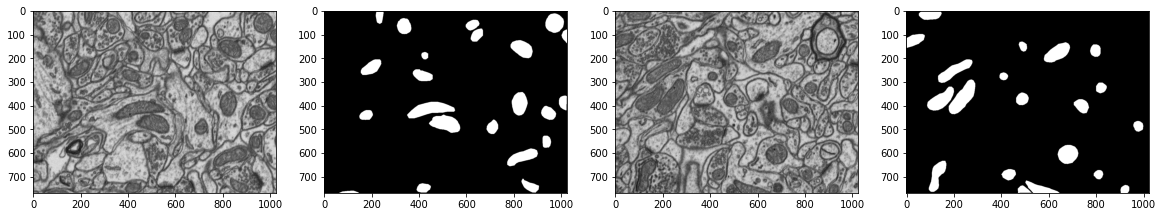

In [12]:
train_x_sample = imread(os.path.join(train_save_data, 'x_000.tif')) 
train_y_sample = imread(os.path.join(train_save_mask, 'y_000.tif')) 
test_x_sample = imread(os.path.join(test_save_data, 'x_000.tif')) 
test_y_sample = imread(os.path.join(test_save_mask, 'y_000.tif')) 

plt.figure(figsize=(20,20))
plt.subplot(1, 4, 1)    
plt.imshow(train_x_sample, cmap='gray')
plt.subplot(1, 4, 2)    
plt.imshow(train_y_sample, cmap='gray')
plt.subplot(1, 4, 3)    
plt.imshow(test_x_sample, cmap='gray')
plt.subplot(1, 4, 4)    
plt.imshow(test_y_sample, cmap='gray')
plt.show()

del train_x_sample, train_y_sample, test_x_sample, test_y_sample

# Run the template!

In [13]:
# 1st arg: absolute path to the repo code  -> '/content/EM_Image_Segmentation'
# 2nd arg: absolute path to the dataset -> '/content/dataset'
# 3rd arg: absolute path where the output data will be generated -> '/content/out_dir'
# 4th arg (--id) : a string to identify the job -> 'test_job' 
# 5th arg (--rid) : number that should be increased when one need to run the same job multiple times -> 0
# 6th arg (--gpu): number of the GPU to run the job in (according to 'nvidia-smi' command) -> 0

!python -u 'EM_Image_Segmentation-1.0/templates/U-Net_2D_template_colab.py' '/content/EM_Image_Segmentation-1.0' '/content/dataset' '/content/out_dir' --id 'test_job' --rid 0 --gpu 0

2021-04-17 16:44:31.114861: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
Python process limited to 1 thread
Date : 2021-04-17 16:44:34
Arguments: Namespace(base_work_dir='/content/EM_Image_Segmentation-1.0', data_dir='/content/dataset', gpu_selected='0', job_id='test_job', result_dir='/content/out_dir', run_id=0)
Python       : 3.7.10 (default, Feb 20 2021, 21:17:23) 
Numpy        : 1.19.5
Keras        : 2.4.0
Tensorflow   : 2.4.1
###################
#  SANITY CHECKS  #
###################

Checking wheter the images in /content/dataset/train/y are binary . . .
Checking wheter the images in /content/dataset/test/y are binary . . .
###############
#  LOAD DATA  #
###############

### LOAD ###
0) Loading train images . . .
Loading data from /content/dataset/train/x
100% 165/165 [00:00<00:00, 1338.64it/s]
*** Loaded data shape is (165, 768, 1024, 1)
1) Loading train masks . . .
Loading data from /content/dataset/trai

# Check results

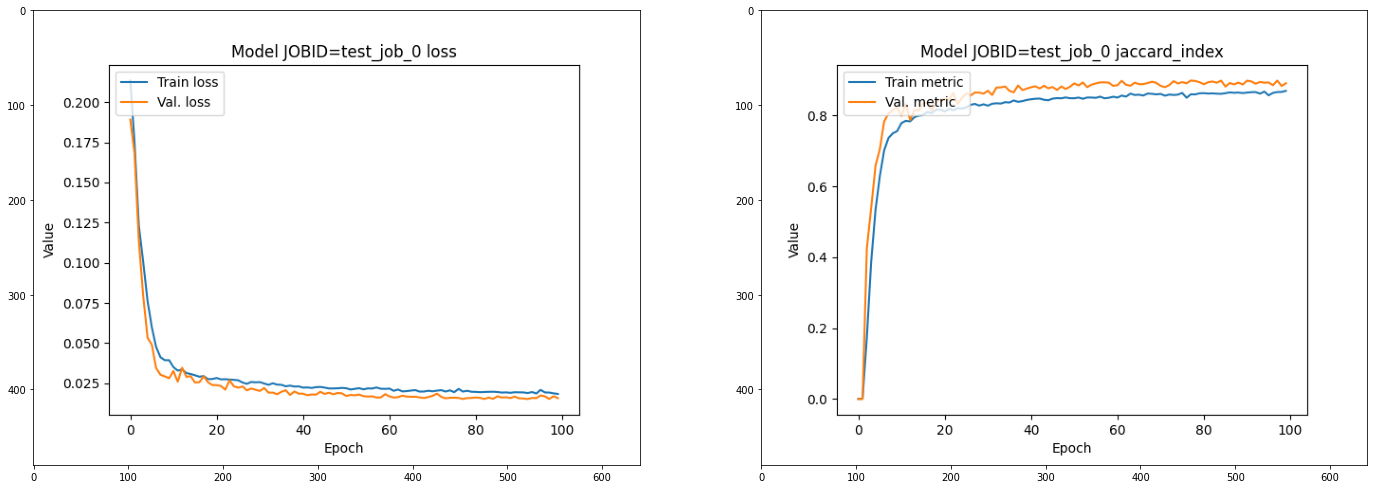

In [14]:
# Visualize training curves 
plt.figure(figsize=(50,50))
plt.subplot(1, 4, 1)    
plt.imshow(imread("/content/out_dir/results/test_job_0/charts/test_job_0_loss.png")) 
plt.subplot(1, 4, 2)    
plt.imshow(imread("/content/out_dir/results/test_job_0/charts/test_job_0_jaccard_index.png"))

In [15]:
# Load some predicted images 
pred = []
pred.append(imread('/content/out_dir/results/test_job_0/full_no_binarized/y_000.png'))
pred.append(imread('/content/out_dir/results/test_job_0/full_8ensemble/y_000.png'))
pred.append(imread('/content/out_dir/results/test_job_0/full_zfil/y_000.png'))

pred.append(imread('/content/out_dir/results/test_job_0/full_no_binarized/y_055.png'))
pred.append(imread('/content/out_dir/results/test_job_0/full_8ensemble/y_055.png'))
pred.append(imread('/content/out_dir/results/test_job_0/full_zfil/y_055.png'))

gt = []
gt.append(imread(os.path.join(test_save_mask, 'y_000.tif'))) 
gt.append(imread(os.path.join(test_save_mask, 'y_055.tif')))

lbl = []
lbl.append("Predicted full-size image")
lbl.append("Ensamble")
lbl.append("Ensamble + Z-Filtering")
lbl.append("Ground Truth")

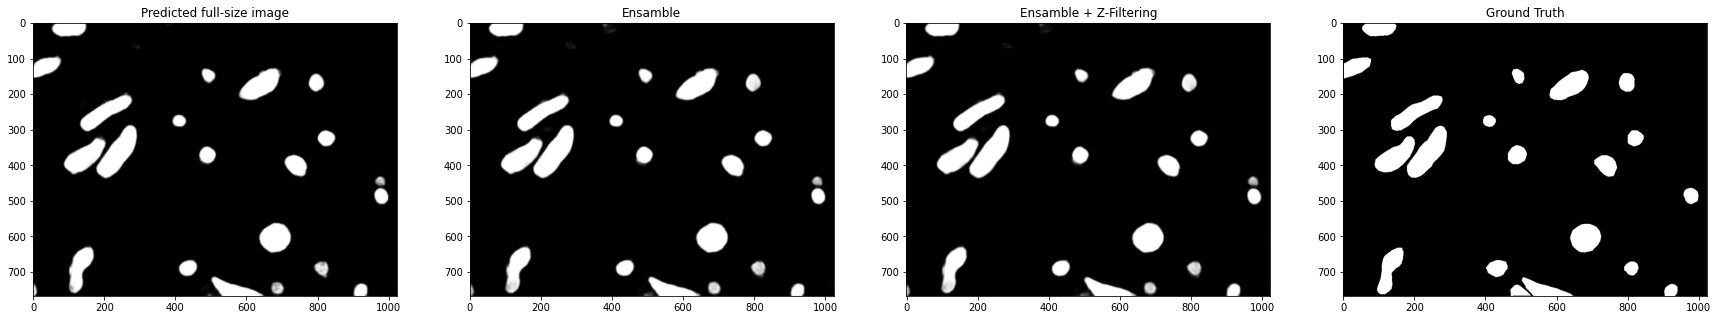

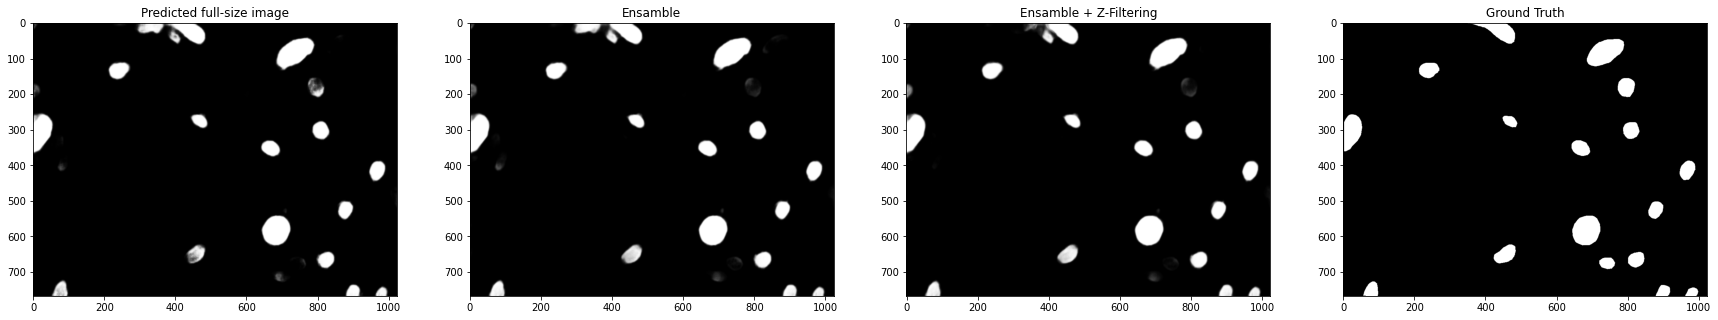

In [16]:
# Show predicted images
for i in range(2):
    plt.figure(figsize=(30,30))
    for j in range(4):
        plt.subplot(i+1, 4, j+1)
        plt.title(lbl[j])
        if j != 3:
            plt.imshow(pred[j+(3*i)], cmap='gray')            
        else:
            plt.imshow(gt[i], cmap='gray')
    plt.show()